# Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub


c:\Users\Asus\OneDrive\Documents\dibimbing bootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Setup

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Load CSV

In [4]:
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
TRAIN_CSV = os.path.join(path, 'Training_set.csv')
TEST_CSV = os.path.join(path, 'Testing_set.csv')
TRAIN_DIR = os.path.join(path, 'train')
TEST_DIR = os.path.join(path, 'test')

In [5]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [6]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


# Data Generator

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='dataset/train',
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='dataset/train',
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='dataset/test',
    x_col='filename',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)


Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


# Building Model

In [ ]:
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  

num_classes = len(train_generator.class_indices)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,627 (9.28 MB)

 Trainable params: 173,643 (678.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training Model

In [9]:
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[earlystop_cb]
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 711s 4s/step - accuracy: 0.0747 - loss: 4.0971 - val_accuracy: 0.5612 - val_loss: 2.2668
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.3690 - loss: 2.4248 - val_accuracy: 0.6998 - val_loss: 1.4306
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.5203 - loss: 1.7633 - val_accuracy: 0.7783 - val_loss: 1.0193
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.5952 - loss: 1.4178 - val_accuracy: 0.7975 - val_loss: 0.8761
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.6525 - loss: 1.2293 - val_accuracy: 0.8176 - val_loss: 0.7664
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.6785 - loss: 1.1211 - val_accuracy: 0.8206 - val_loss: 0.6937
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.7117 - loss: 0.9691 - val_accuracy: 0.8253 - val_loss: 0.6586
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7149 - loss: 0.9418 - val_accu

In [10]:
model.save('butterfly_model.h5')

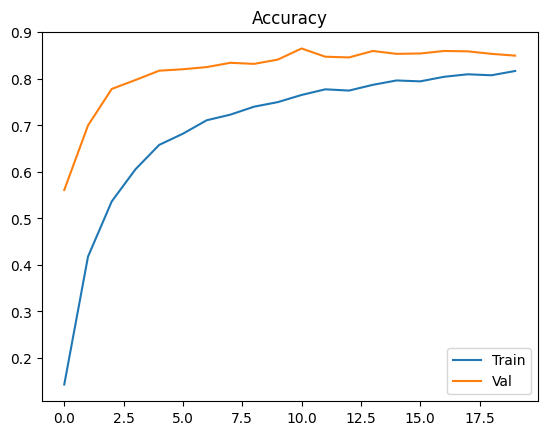

In [11]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()


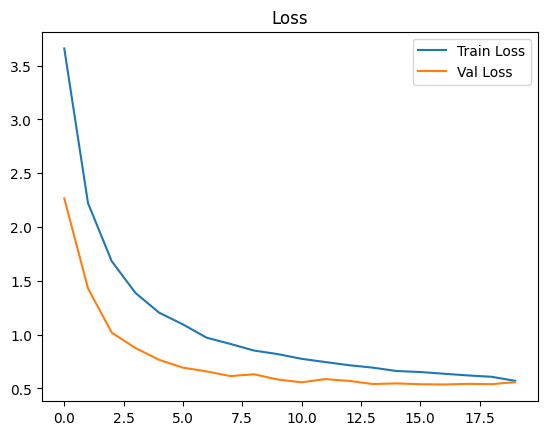

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Model Evaluation

In [13]:
preds = model.predict(test_generator)
pred_classes = np.argmax(preds, axis=1)

label_map = {v: k for k, v in train_generator.class_indices.items()}
pred_labels = [label_map[i] for i in pred_classes]

test_df['label'] = pred_labels


88/88 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step


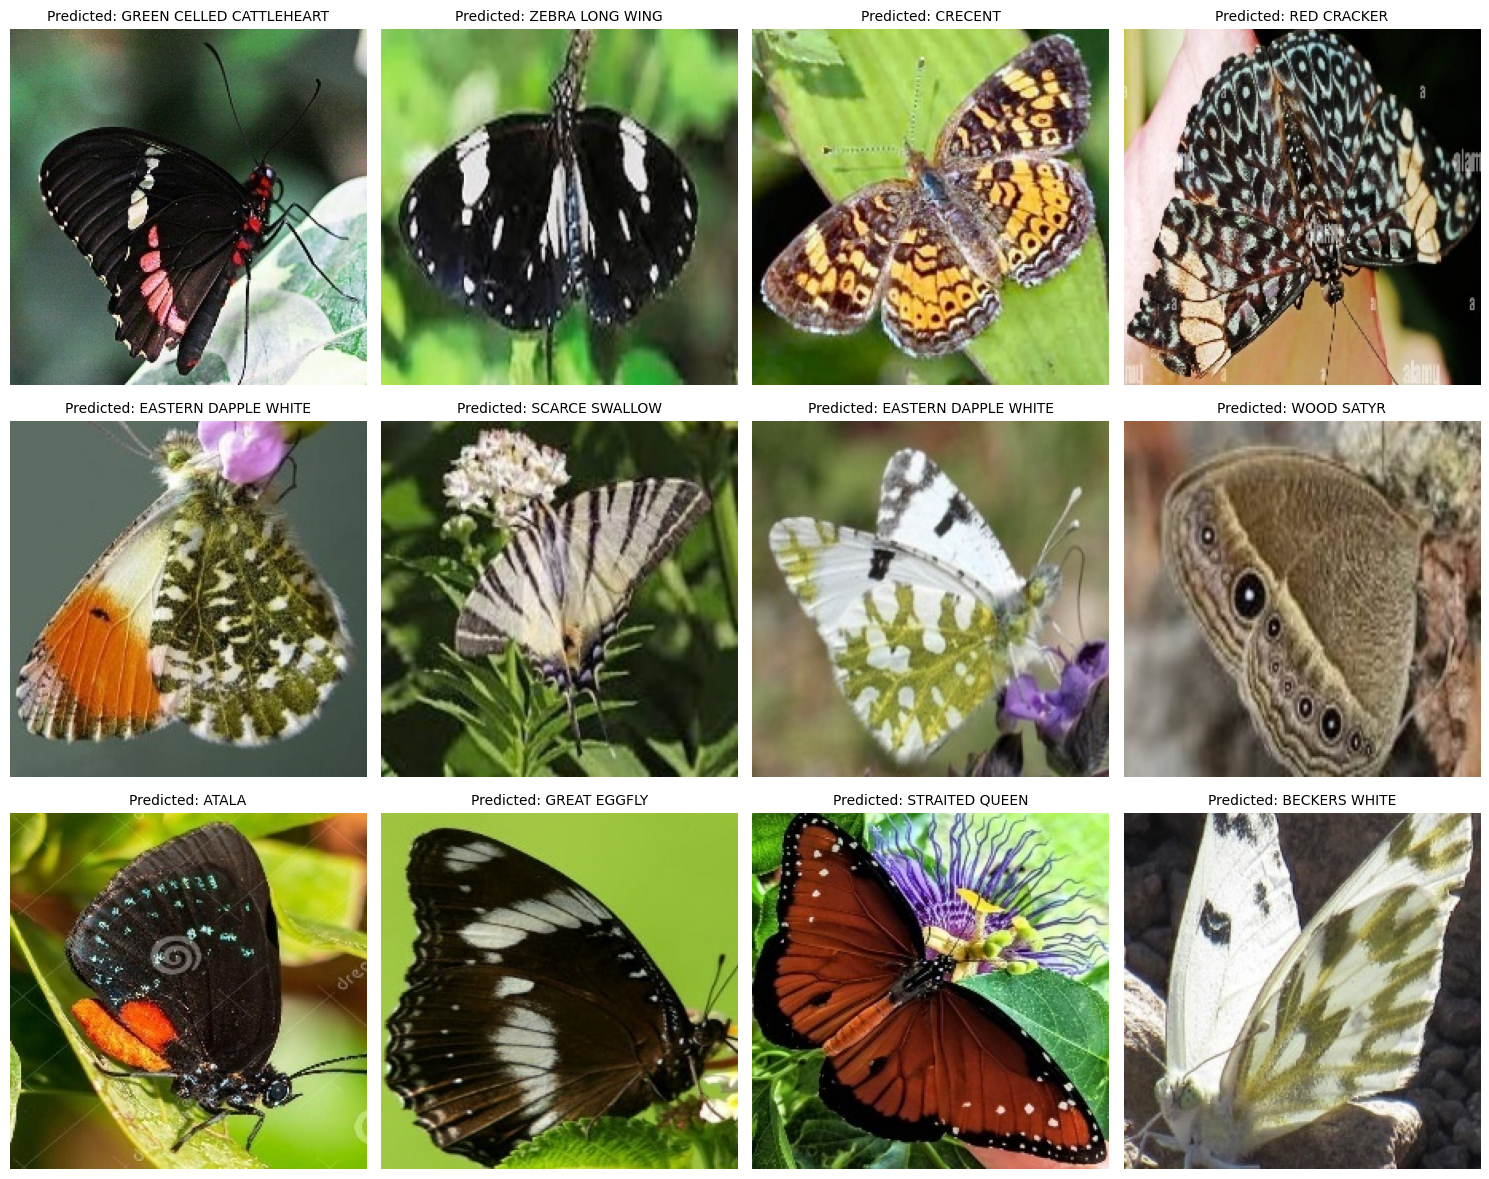

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

num_images = 12

image_dir = 'dataset/test'

sample_df = test_df.sample(n=num_images, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 12))
for i in range(num_images):
    img_path = os.path.join(image_dir, sample_df.loc[i, 'filename'])
    img = mpimg.imread(img_path)
    
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {sample_df.loc[i, 'label']}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
